<a href="https://colab.research.google.com/github/Jhin0820/GIScience_2023_Tutorial_LVLM/blob/main/GIScience_VLM_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Large Visual Language Model Tutorial**


*   Visual Language Model (VLM) is a deep learning model that combines Computer

*   Vision (CV) and Natural Language Processing (NLP).

*   The model aims to understand and generate text asscociated with images, or to understand and generate image content from text.

*   VLM includes bimodality: Text and/or Image. It can extract visual features from images and linguistic features from text, and then combine these two features for various tasks.

*   The common applications of VLM are image capitioning, visual question answering, image retrieval, image generation, and so on.





## **1. CLIP: Learning Transferable Visual Models From Natural Language Supervision**


*   CLIP is the base model for the Big Visual Language Model, proposed by OpenAI in 2021.

*   CLIP spatially aligns the coding vectors of the models trained on each of images and text by learning from the comparison of massive amounts of weakly supervised image text pairs.



### Preparation for Colab

Prepare necessary packages for CLIP.




In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-i6y93ail
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-i6y93ail
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=4d0e66609c71b446d3d3b663685a1a521aff70f90f0ddccb7813282a3df43ce4
  Stored in directory: /tmp/pip-ephem-wheel-cache-hsio9tt5/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


Prepare PyTorch environment for CLIP.

In [2]:
import torch
torch.__version__

'2.0.1+cu118'

GPU is alternative.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Loading the Model

Import CLIP and check available models.

In [4]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

Load CLIP model - ViT-B/32

In [5]:
model, preprocess = clip.load('ViT-B/32', device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 241MiB/s]


### Loading the Dataset

You can use your own image dataset in this step. \
Import 'requests' to capture the test image, and 'PIL' to visualise the image.

In [6]:
from PIL import Image
import requests

Load a test image which is a picture of UCL main campus.

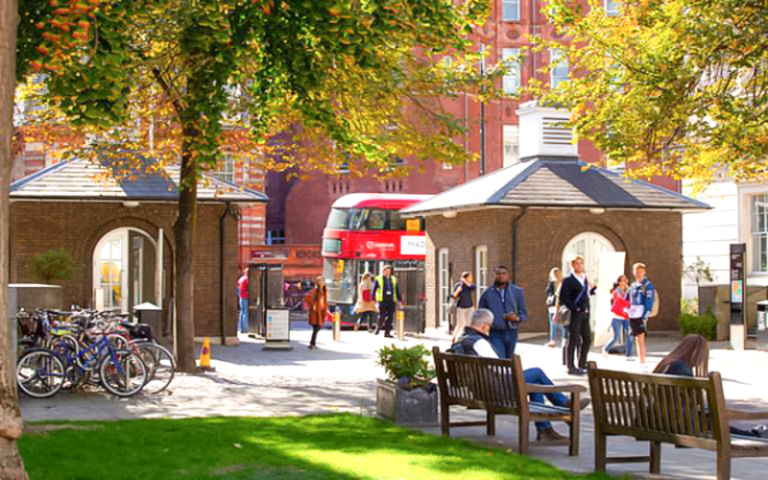

In [7]:
img_url = 'https://www.ucl.ac.uk/news/sites/news/files/styles/large_image/public/ucl_main_building.png?itok=fQHHwEaK'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
raw_image

100 possible classes of realistic scenes.  \
(You can input any class to test.)

In [8]:
classes = ["street",
"campus",
"underground",
"beach",
"mountain",
"forest",
"desert",
"countryside",
"city",
"village",
"park",
"river",
"lake",
"ocean",
"island",
"airport",
"train station",
"subway station",
"shopping mall",
"cafe",
"restaurant",
"library",
"museum",
"zoo",
"amusement park",
"theater",
"cinema",
"stadium",
"swimming pool",
"garden",
"farm",
"factory",
"church",
"temple",
"port",
"bridge",
"hotel",
"hospital",
"school",
"university",
"office",
"construction site",
"beach",
"dam",
"waterfall",
"cave",
"prairie",
"swamp",
"rainforest",
"glacier"]

### Building Features

CLIP use a case-insensitive tokenizer, which can be invoked using clip.tokenize(). By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [9]:
image_input = preprocess(raw_image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

CLIP normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [10]:
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

### Calculating Cosine Similarity

CLIP normalize the features and calculate the dot product of each pair.

In [11]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(10)

### Predicting Image-Text Similarity

In [12]:
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

          campus: 54.74%
      university: 22.50%
          school: 3.56%
            park: 2.74%
         library: 2.17%
            cafe: 1.83%
          garden: 1.78%
          street: 1.76%
   train station: 1.64%
        hospital: 1.42%


## **2. BLIP-2: Bootstrapping Language-Image Pre-training with Frozen Image Encoders and Large Language Models**

### Preparation for Colab

Prepare necessary packages for BLIP-2.

In [13]:
import sys
!pip3 install salesforce-lavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 25.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━

### Loading the Model

Import CLIP and load the simplest BLIP-2 model. \
If your computer allow, you can use 'blip2_t5' as name input and 'flant_xxl' as model_type.

In [14]:
from lavis.models import load_model_and_preprocess

In [15]:
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2", model_type="pretrain", is_eval=True, device=device
)

100%|██████████| 1.89G/1.89G [00:34<00:00, 58.3MB/s]


100%|██████████| 712M/712M [00:06<00:00, 118MB/s] 


### Loading the Dataset

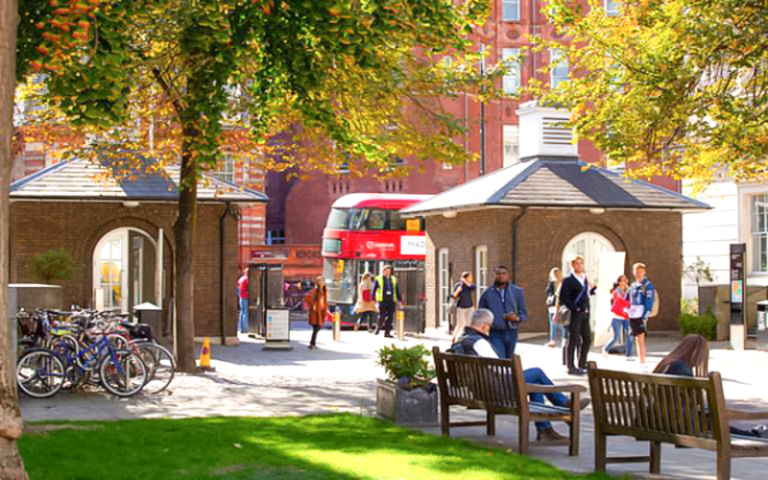

In [16]:
raw_image

In [17]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

### Captioning the Input Image

In [18]:
model.generate({"image": image})

['a group of people walking and sitting on benches in front of a building']

Additional Function from BLIP-2 Web Demo - VQA

https://huggingface.co/spaces/Salesforce/BLIP2